### Colab Specific

In [1]:
!cp /content/drive/MyDrive/senior_ds_test.zip .

In [2]:
!unzip senior_ds_test.zip

Archive:  senior_ds_test.zip
   creating: senior_ds_test/
   creating: senior_ds_test/.ipynb_checkpoints/
   creating: senior_ds_test/data/
   creating: senior_ds_test/data/.ipynb_checkpoints/
   creating: senior_ds_test/data/final_submission/
  inflating: senior_ds_test/data/final_submission/sample_submission.csv  
   creating: senior_ds_test/data/test/
  inflating: senior_ds_test/data/test/accounts_data_test.json  
  inflating: senior_ds_test/data/test/enquiry_data_test.json  
  inflating: senior_ds_test/data/test/test_flag.csv  
   creating: senior_ds_test/data/train/
  inflating: senior_ds_test/data/train/accounts_data_train.json  
  inflating: senior_ds_test/data/train/enquiry_data_train.json  
  inflating: senior_ds_test/data/train/train_flag.csv  
  inflating: senior_ds_test/problem_statement.pdf  


### Load Library and Data

In [3]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,plot_importance

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [4]:
def read_json(file_path):
  with open(file_path) as f:
    tmp = json.load(f)
  l = [pd.DataFrame(data) for data in tmp]
  df = pd.concat(l,ignore_index=True,sort=False)
  return df

In [5]:
sub = pd.read_csv('senior_ds_test/data/final_submission/sample_submission.csv')

accounts_data_train = read_json('senior_ds_test/data/train/accounts_data_train.json')
enquiry_data_train = read_json('senior_ds_test/data/train/enquiry_data_train.json')
train_flag = pd.read_csv('senior_ds_test/data/train/train_flag.csv')

accounts_data_test = read_json('senior_ds_test/data/test/accounts_data_test.json')
enquiry_data_test = read_json('senior_ds_test/data/test/enquiry_data_test.json')
test_flag = pd.read_csv('senior_ds_test/data/test/test_flag.csv')

### Data understanding & Preparation

In [ ]:
accounts_data_train.shape,accounts_data_train['uid'].nunique()

((1245310, 7), 223918)

In [ ]:
accounts_data_train.head(1)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550


In [ ]:
#some uid doesn't have accounts_data_train, so they can be new customers
train_flag[~train_flag['uid'].isin(accounts_data_train['uid'])].head()

,uid,NAME_CONTRACT_TYPE,TARGET
4,WJZ68772744,Cash loans,0
7,DBK56652751,Cash loans,1
13,VJY65237599,Cash loans,0
25,CDR05672029,Cash loans,0
27,GYL79147955,Cash loans,1


In [ ]:
#some uid doesn't have accounts_data_train, so they can be new customers
train_flag['TARGET'][~train_flag['uid'].isin(accounts_data_train['uid'])].value_counts(normalize=1)

0    0.898572
1    0.101428
Name: TARGET, dtype: float64

In [ ]:
enquiry_data_train.groupby(['uid']).agg({'enquiry_type':'nunique'}).reset_index().sort_values(by='enquiry_type',ascending=False).head()

,uid,enquiry_type
53889,FJQ51514651,17
57488,FSW73151740,17
208325,USM18365186,17
181198,SAD05487757,17
219540,VVB28407158,17


In [ ]:
train_flag.shape,train_flag['uid'].nunique()

((261383, 3), 261383)

In [ ]:
test_flag.shape,test_flag['uid'].nunique()

((46127, 2), 46127)

In [ ]:
accounts_data_train.isna().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

In [ ]:
enquiry_data_train.shape,enquiry_data_train['uid'].nunique()

((1909926, 4), 261383)

In [ ]:
set(enquiry_data_train['enquiry_type']).issuperset(enquiry_data_test['enquiry_type'])

True

In [ ]:
set(accounts_data_train['credit_type']).issuperset(accounts_data_test['credit_type'])

True

In [ ]:
set(enquiry_data_train['enquiry_type']).issuperset(accounts_data_train['credit_type'])

True

In [ ]:
train_flag['TARGET'].value_counts(normalize=1)

0    0.91944
1    0.08056
Name: TARGET, dtype: float64

In [ ]:
sorted()

### Data Preparation

In [6]:
def count_bad_payment(payment_hist_string):
  count = 0
  for i in range(0,len(payment_hist_string),3):
    val = int(payment_hist_string[i:i+3])
    if val > 7:
      count += 1
  return count

# Assuming more than 1 week Late as Fatal Late Payment,i.e, not due to forgetting payment date, technical issue etc.
accounts_data_train['count_late_payment'] = accounts_data_train['payment_hist_string'].apply(count_bad_payment)

In [7]:
accounts_data_train['open_date'] = pd.to_datetime(accounts_data_train['open_date'])
accounts_data_train['closed_date'] = pd.to_datetime(accounts_data_train['closed_date'])

### Fill Null values : closed_date = open_date + payment_duration
accounts_data_train['closed_date'] = np.where(accounts_data_train['closed_date'].isna(),
                                              accounts_data_train[['open_date','payment_hist_string']].apply(lambda x: x[0] + pd.DateOffset(months=len(x[1])//3),axis=1),
                                              accounts_data_train['closed_date'])
accounts_data_train['loan_duration'] = (accounts_data_train['closed_date'] - accounts_data_train['open_date']).dt.days

In [8]:
### Make all credit type in columns and fill values with count of rows for each uid
credit_type_count = pd.crosstab(accounts_data_train['uid'],accounts_data_train['credit_type']).reset_index()
### UID level for amount variables
credit_amounts = accounts_data_train.groupby(['uid']).agg({'loan_amount':['sum','min','max','count'],
                                                     'amount_overdue':['sum','min','max','count'],
                                                     'count_late_payment':['sum','min','max','count'],
                                                     'loan_duration':['sum','min','max','count']}).reset_index()
credit_amounts.columns = credit_amounts.columns.map('_'.join)
credit_amounts.rename(columns={'uid_':'uid'},inplace=True)

In [9]:
uid_level = pd.merge(credit_type_count,credit_amounts,how='inner',on=['uid'])
### Merge with Train_Flag
uid_level = pd.merge(uid_level,train_flag,how='inner',on=['uid'])
uid_level.fillna(0,inplace=True)
uid_level = pd.get_dummies(uid_level,columns=['NAME_CONTRACT_TYPE']) #Only categorcial column
uid_level.isna().sum().sum()

0

In [10]:
enquiry_type_count = pd.crosstab(enquiry_data_train['uid'],enquiry_data_train['enquiry_type']).reset_index()
enquiry_amt = enquiry_data_train.groupby(['uid']).agg({'enquiry_amt':['sum','min','max','count']}).reset_index()
enquiry_amt.columns = enquiry_amt.columns.map('_'.join)
enquiry_amt.rename(columns={'uid_':'uid'},inplace=True)
enquiry = pd.merge(enquiry_type_count,enquiry_amt,how='inner',on=['uid'])
enquiry.fillna(0,inplace=True)
enquiry.isna().sum().sum()

0

In [11]:
uid_level_old = uid_level.copy()
uid_level = pd.merge(uid_level,enquiry,how='right',on=['uid'],suffixes=('_account','_enquiry'))
uid_level.fillna(0,inplace=True)

In [27]:
date_features = pd.merge(accounts_data_train[['uid','credit_type','loan_amount', 'amount_overdue', 'open_date',
       'closed_date']],
       enquiry_data_train, how='inner',on=['uid'])

date_features['enquiry_time'] = np.where(date_features['open_date'] > date_features['enquiry_date'],'Before',
                                         np.where(date_features['closed_date'] < date_features['enquiry_date'],'After','During'))

date_features['loan_enquiry_comparison'] = np.where(date_features['enquiry_amt'] < date_features['loan_amount'],'Enquiry_less_Loan',
                                                    'Enquiry_more_loan')
date_features['credit_enquiry'] = np.where(date_features['credit_type'] == date_features['enquiry_type'],'same','diff') 
date_features = pd.get_dummies(date_features,columns=['enquiry_time','loan_enquiry_comparison','credit_enquiry'])
date_features = date_features.groupby(['uid']).agg({'enquiry_time_After':['sum','mean','max','min'],
                                    'enquiry_time_Before':['sum','mean','max','min'],
                                    'enquiry_time_During':['sum','mean','max','min'],
       'loan_enquiry_comparison_Enquiry_less_Loan':['sum','mean','max','min'],
       'loan_enquiry_comparison_Enquiry_more_loan':['sum','mean','max','min'], 'credit_enquiry_diff':['sum','mean','max','min'],
       'credit_enquiry_same':['sum','mean','max','min']}).reset_index()

date_features.columns = date_features.columns.map('_'.join)
date_features.rename(columns={'uid_':'uid'},inplace=True)
date_features.head()


,uid,credit_type,loan_amount,amount_overdue,open_date,closed_date,enquiry_type,enquiry_amt,enquiry_date,enquiry_time_After,enquiry_time_Before,enquiry_time_During,loan_enquiry_comparison_Enquiry_less_Loan,loan_enquiry_comparison_Enquiry_more_loan,credit_enquiry_diff,credit_enquiry_same
0,AAA09044550,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,Cash loans,120000,2019-08-19,0,0,1,1,0,1,0
1,AAA09044550,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,Interbank credit,197000,2019-11-01,0,0,1,1,0,1,0
2,AAA09044550,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,Car loan,127000,2020-06-21,1,0,0,1,0,1,0
3,AAA09044550,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,Revolving loans,94000,2020-06-11,1,0,0,1,0,1,0
4,AAA09044550,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,Car loan,120000,2020-10-19,1,0,0,1,0,1,0


In [31]:
uid_level_without_date_features = uid_level.copy()
uid_level = pd.merge(uid_level,date_features,how='left',on=['uid'])
uid_level.fillna(0,inplace=True)
uid_level.shape

### EDA

In [53]:
for col in uid_level.columns:
  if uid_level[col].nunique() < 50:
    tmp = pd.crosstab(uid_level[col],uid_level['TARGET']).reset_index()
    tmp['Total_Loan'] = tmp[0] + tmp[1]
    tmp['Total_Loan_Dist'] = 100*tmp['Total_Loan']/tmp['Total_Loan'].sum()
    tmp['bad_loan_ratio'] = 100*tmp[1]/tmp['Total_Loan']
    tmp['bad_loan_dist'] = 100*tmp[1]/tmp[1].sum()
    tmp['good_loan_dist'] = 100*tmp[0]/tmp[0].sum()
    display(tmp)
  else:
    try:
      tmp = uid_level.groupby(['TARGET']).agg({col:'describe'}).reset_index()
      display(tmp)
    except:
      print(col)

TARGET     uid                          
           count  unique          top freq
0    0.0  244126  244126  AAA08065248    1
1    1.0   17257   17257  AAB67762691    1

TARGET,Another type of loan_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,243480,17205,260685,99.732959,6.599919,99.698673,99.735383
1,1.0,620,51,671,0.256711,7.600596,0.295532,0.253967
2,2.0,21,1,22,0.008417,4.545455,0.005795,0.008602
3,3.0,3,0,3,0.001148,0.000000,0.000000,0.001229
4,4.0,2,0,2,0.000765,0.000000,0.000000,0.000819


TARGET,Car loan_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,228439,16294,244733,93.630037,6.657868,94.419656,93.574220
1,1.0,12971,818,13789,5.275400,5.932265,4.740105,5.313240
2,2.0,2175,126,2301,0.880317,5.475880,0.730138,0.890933
3,3.0,426,17,443,0.169483,3.837472,0.098511,0.174500
4,4.0,83,1,84,0.032137,1.190476,0.005795,0.033999
5,5.0,23,1,24,0.009182,4.166667,0.005795,0.009421
6,6.0,5,0,5,0.001913,0.000000,0.000000,0.002048
7,7.0,2,0,2,0.000765,0.000000,0.000000,0.000819
8,8.0,1,0,1,0.000383,0.000000,0.000000,0.000410
9,9.0,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Cash loan (non-earmarked)_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244112,17256,261368,99.994261,6.602185,99.994205,99.994265
1,1.0,12,1,13,0.004974,7.692308,0.005795,0.004915
2,2.0,2,0,2,0.000765,0.000000,0.000000,0.000819


TARGET Consumer credit_account                                              
                           count      mean       std  min  25%  50%  75%   max
0    0.0                244126.0  3.443173  3.538169  0.0  1.0  3.0  5.0  86.0
1    1.0                 17257.0  3.950455  3.558820  0.0  1.0  3.0  5.0  54.0

TARGET,Credit card_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,109623,5401,115024,44.005922,4.695542,31.297445,44.904271
1,1.0,67741,5460,73201,28.005264,7.458914,31.639335,27.748376
2,2.0,34184,2986,37170,14.220512,8.033360,17.303123,14.002605
3,3.0,16620,1599,18219,6.970231,8.776552,9.265805,6.807960
4,4.0,7930,824,8754,3.349108,9.412840,4.774874,3.248323
5,5.0,3864,466,4330,1.656573,10.762125,2.700353,1.582789
6,6.0,1990,219,2209,0.845120,9.913988,1.269050,0.815153
7,7.0,1042,120,1162,0.444558,10.327022,0.695370,0.426829
8,8.0,501,71,572,0.218836,12.412587,0.411427,0.205222
9,9.0,294,45,339,0.129695,13.274336,0.260764,0.120430


TARGET,Interbank credit_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244125,17257,261382,99.999617,6.602214,100.0,99.99959
1,1.0,1,0,1,0.000383,0.000000,0.0,0.00041


TARGET,Loan for business development_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,243012,17186,260198,99.546642,6.604970,99.588573,99.543678
1,1.0,931,59,990,0.378755,5.959596,0.341890,0.381360
2,2.0,126,10,136,0.052031,7.352941,0.057947,0.051613
3,3.0,37,1,38,0.014538,2.631579,0.005795,0.015156
4,4.0,16,1,17,0.006504,5.882353,0.005795,0.006554
5,5.0,2,0,2,0.000765,0.000000,0.000000,0.000819
6,6.0,2,0,2,0.000765,0.000000,0.000000,0.000819


TARGET,Loan for purchase of shares (margin lending)_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244122,17257,261379,99.99847,6.60229,100.0,99.998362
1,1.0,4,0,4,0.00153,0.00000,0.0,0.001638


TARGET,Loan for the purchase of equipment_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244114,17254,261368,99.994261,6.601420,99.982616,99.995085
1,1.0,12,2,14,0.005356,14.285714,0.011589,0.004915
2,2.0,0,1,1,0.000383,100.000000,0.005795,0.000000


TARGET,Loan for working capital replenishment_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,243887,17217,261104,99.893260,6.593924,99.768210,99.902100
1,1.0,213,38,251,0.096028,15.139442,0.220200,0.087250
2,2.0,19,2,21,0.008034,9.523810,0.011589,0.007783
3,3.0,4,0,4,0.001530,0.000000,0.000000,0.001638
4,5.0,3,0,3,0.001148,0.000000,0.000000,0.001229


TARGET,Microloan_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,241737,16657,258394,98.856467,6.446357,96.523150,99.021407
1,1.0,1291,313,1604,0.613659,19.513716,1.813757,0.528825
2,2.0,439,106,545,0.208506,19.449541,0.614243,0.179825
3,3.0,217,53,270,0.103297,19.629630,0.307122,0.088889
4,4.0,127,42,169,0.064656,24.852071,0.243379,0.052022
5,5.0,85,21,106,0.040554,19.811321,0.121690,0.034818
6,6.0,57,12,69,0.026398,17.391304,0.069537,0.023349
7,7.0,32,10,42,0.016068,23.809524,0.057947,0.013108
8,8.0,32,4,36,0.013773,11.111111,0.023179,0.013108
9,9.0,21,10,31,0.011860,32.258065,0.057947,0.008602


TARGET,Mobile operator loan_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244125,17257,261382,99.999617,6.602214,100.0,99.99959
1,1.0,1,0,1,0.000383,0.000000,0.0,0.00041


TARGET,Mortgage_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,232657,16628,249285,95.371543,6.670277,96.355102,95.302016
1,1.0,10534,595,11129,4.257737,5.346392,3.447876,4.314985
2,2.0,845,31,876,0.335140,3.538813,0.179637,0.346133
3,3.0,70,2,72,0.027546,2.777778,0.011589,0.028674
4,4.0,16,1,17,0.006504,5.882353,0.005795,0.006554
5,5.0,2,0,2,0.000765,0.000000,0.000000,0.000819
6,8.0,1,0,1,0.000383,0.000000,0.000000,0.000410
7,13.0,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Real estate loan_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244109,17257,261366,99.993496,6.602619,100.0,99.993036
1,1.0,17,0,17,0.006504,0.000000,0.0,0.006964


TARGET,Unknown type of loan_account,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,243812,17235,261047,99.871453,6.602259,99.872516,99.871378
1,1.0,280,21,301,0.115157,6.976744,0.121690,0.114695
2,2.0,31,1,32,0.012243,3.125000,0.005795,0.012698
3,3.0,3,0,3,0.001148,0.000000,0.000000,0.001229


TARGET loan_amount_sum                                                 \
                   count          mean           std  min           25%   
0    0.0        244126.0  1.672750e+06  4.084593e+06  0.0  141070.19625   
1    1.0         17257.0  1.763182e+06  2.608918e+06  0.0  301500.00000   

                                           
           50%          75%           max  
0  697193.4825  1952437.275  1.017958e+09  
1  904126.5000  2189933.910  5.478038e+07

TARGET loan_amount_min                                                \
                   count           mean            std  min        25%   
0    0.0        244126.0  102943.864711  552620.369392  0.0      0.000   
1    1.0         17257.0   97155.597282  415288.199686  0.0  14077.395   

                                     
        50%        75%          max  
0  28866.78  75310.605  142290000.0  
1  35293.50  83925.000   35190000.0

TARGET loan_amount_max                                              \
                   count           mean           std  min       25%   
0    0.0        244126.0  837718.910204  2.054593e+06  0.0   93105.0   
1    1.0         17257.0  834409.180929  1.340575e+06  0.0  172192.5   

                                    
        50%       75%          max  
0  315000.0  900000.0  396000000.0  
1  450000.0  970524.0   35190000.0

TARGET loan_amount_count                                               
                     count      mean       std  min  25%  50%  75%    max
0    0.0          244126.0  4.701609  4.481959  0.0  1.0  4.0  7.0  116.0
1    1.0           17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   55.0

TARGET amount_overdue_sum                                                 \
                      count         mean           std  min  25%  50%  75%   
0    0.0           244126.0   142.075560  14542.028745  0.0  0.0  0.0  0.0   
1    1.0            17257.0  1022.609737  29216.663538  0.0  0.0  0.0  0.0   

              
         max  
0  3756681.0  
1  2387232.0

TARGET amount_overdue_min                                              \
                      count       mean          std  min  25%  50%  75%   
0    0.0           244126.0  13.015602  4281.650188  0.0  0.0  0.0  0.0   
1    1.0            17257.0  10.500056   627.441508  0.0  0.0  0.0  0.0   

                
           max  
0  1617403.500  
1    51950.475

TARGET amount_overdue_max                                                \
                      count        mean           std  min  25%  50%  75%   
0    0.0           244126.0  128.970470  13474.949829  0.0  0.0  0.0  0.0   
1    1.0            17257.0  746.336977  22556.867949  0.0  0.0  0.0  0.0   

              
         max  
0  3756681.0  
1  2387232.0

TARGET amount_overdue_count                                               
                        count      mean       std  min  25%  50%  75%    max
0    0.0             244126.0  4.701621  4.481959  0.0  1.0  4.0  7.0  116.0
1    1.0              17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   55.0

TARGET count_late_payment_sum                                               
                          count      mean       std  min  25%  50%  75%    max
0    0.0               244126.0  1.221054  3.619913  0.0  0.0  0.0  1.0  102.0
1    1.0                17257.0  1.383265  3.922575  0.0  0.0  0.0  1.0   95.0

TARGET,count_late_payment_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,241933,17026,258959,99.072625,6.574786,98.661413,99.101693
1,1.0,986,111,1097,0.419691,10.118505,0.643217,0.403890
2,2.0,462,48,510,0.195116,9.411765,0.278148,0.189247
3,3.0,237,21,258,0.098706,8.139535,0.121690,0.097081
4,4.0,120,7,127,0.048588,5.511811,0.040563,0.049155
5,5.0,88,8,96,0.036728,8.333333,0.046358,0.036047
6,6.0,67,5,72,0.027546,6.944444,0.028974,0.027445
7,7.0,45,2,47,0.017981,4.255319,0.011589,0.018433
8,8.0,31,4,35,0.013390,11.428571,0.023179,0.012698
9,9.0,25,0,25,0.009565,0.000000,0.000000,0.010241


TARGET count_late_payment_max                                              
                          count      mean       std  min  25%  50%  75%   max
0    0.0               244126.0  1.068477  3.185123  0.0  0.0  0.0  1.0  81.0
1    1.0                17257.0  1.184910  3.326560  0.0  0.0  0.0  1.0  78.0

TARGET count_late_payment_count                                          \
                            count      mean       std  min  25%  50%  75%   
0    0.0                 244126.0  4.701621  4.481959  0.0  1.0  4.0  7.0   
1    1.0                  17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   

          
     max  
0  116.0  
1   55.0

TARGET loan_duration_sum                                                    \
                     count         mean          std      min    25%     50%   
0    0.0          244126.0  2364.386931  2581.154567 -32839.0  373.0  1584.0   
1    1.0           17257.0  2591.400012  2603.919854      0.0  708.0  1810.0   

                    
      75%      max  
0  3488.0  31357.0  
1  3625.0  37705.0

TARGET loan_duration_min                                                \
                     count        mean         std      min   25%    50%   
0    0.0          244126.0  176.455122  267.671222 -39683.0  30.0  120.0   
1    1.0           17257.0  189.801704  259.811984      0.0  61.0  122.0   

                  
     75%     max  
0  214.0  2953.0  
1  214.0  2953.0

TARGET loan_duration_max                                                     \
                     count        mean         std  min    25%    50%     75%   
0    0.0          244126.0  859.300136  735.714668  0.0  275.0  731.0  1286.0   
1    1.0           17257.0  917.708524  671.695667  0.0  367.0  761.0  1280.0   

           
      max  
0  2953.0  
1  2953.0

TARGET loan_duration_count                                               
                       count      mean       std  min  25%  50%  75%    max
0    0.0            244126.0  4.701621  4.481959  0.0  1.0  4.0  7.0  116.0
1    1.0             17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   55.0

TARGET,TARGET,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,244126,0,244126,93.397811,0.0,0.0,100.0
1,1.0,0,17257,17257,6.602189,100.0,100.0,0.0


TARGET,NAME_CONTRACT_TYPE_Cash loans,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,57429,1092,58521,22.388985,1.865997,6.327867,23.524328
1,1.0,186697,16165,202862,77.611015,7.968471,93.672133,76.475672


TARGET,NAME_CONTRACT_TYPE_Revolving loans,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,224162,16165,240327,91.944388,6.726252,93.672133,91.822256
1,1.0,19964,1092,21056,8.055612,5.186170,6.327867,8.177744


TARGET,Another type of loan_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175341,12306,187647,71.790055,6.558058,71.310193,71.823976
1,1,50962,3678,54640,20.904190,6.731332,21.313090,20.875286
2,2,13333,954,14287,5.465925,6.677399,5.528191,5.461524
3,3,3414,236,3650,1.396418,6.465753,1.367561,1.398458
4,4,838,57,895,0.342409,6.368715,0.330301,0.343265
5,5,182,16,198,0.075751,8.080808,0.092716,0.074552
6,6,39,7,46,0.017599,15.217391,0.040563,0.015975
7,7,16,1,17,0.006504,5.882353,0.005795,0.006554
8,8,1,1,2,0.000765,50.000000,0.005795,0.000410
9,9,0,1,1,0.000383,100.000000,0.005795,0.000000


TARGET,Car loan_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175510,12316,187826,71.858537,6.557133,71.368140,71.893203
1,1,50918,3621,54539,20.865550,6.639286,20.982790,20.857262
2,2,13160,982,14142,5.410451,6.943855,5.690444,5.390659
3,3,3452,234,3686,1.410191,6.348345,1.355971,1.414024
4,4,835,79,914,0.349678,8.643326,0.457785,0.342036
5,5,195,23,218,0.083403,10.550459,0.133279,0.079877
6,6,41,2,43,0.016451,4.651163,0.011589,0.016795
7,7,12,0,12,0.004591,0.000000,0.000000,0.004915
8,8,2,0,2,0.000765,0.000000,0.000000,0.000819
9,9,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Cash loan (non-earmarked)_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175504,12425,187929,71.897943,6.611539,71.999768,71.890745
1,1,50821,3569,54390,20.808545,6.561868,20.681463,20.817529
2,2,13321,931,14252,5.452535,6.532417,5.394912,5.456608
3,3,3436,241,3677,1.406748,6.554256,1.396535,1.407470
4,4,794,62,856,0.327489,7.242991,0.359274,0.325242
5,5,190,19,209,0.079959,9.090909,0.110100,0.077829
6,6,47,7,54,0.020659,12.962963,0.040563,0.019252
7,7,12,3,15,0.005739,20.000000,0.017384,0.004915
8,8,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Cash loans,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,109174,7606,116780,44.677733,6.513102,44.074868,44.720349
1,1,64808,4587,69395,26.549163,6.609986,26.580518,26.546947
2,2,32627,2364,34991,13.386869,6.756023,13.698789,13.364820
3,3,17669,1291,18960,7.253723,6.809072,7.481022,7.237656
4,4,9583,643,10226,3.912267,6.287894,3.726024,3.925432
5,5,5033,400,5433,2.078559,7.362415,2.317900,2.061640
6,6,2640,189,2829,1.082320,6.680806,1.095208,1.081409
7,7,1343,92,1435,0.549003,6.411150,0.533117,0.550126
8,8,698,45,743,0.284257,6.056528,0.260764,0.285918
9,9,273,21,294,0.112479,7.142857,0.121690,0.111827


TARGET,Consumer credit_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175494,12390,187884,71.880727,6.594494,71.796952,71.886649
1,1,50915,3642,54557,20.872436,6.675587,21.104479,20.856033
2,2,13246,912,14158,5.416573,6.441588,5.284812,5.425887
3,3,3432,238,3670,1.404070,6.485014,1.379150,1.405831
4,4,805,60,865,0.330932,6.936416,0.347685,0.329748
5,5,176,11,187,0.071543,5.882353,0.063742,0.072094
6,6,46,3,49,0.018746,6.122449,0.017384,0.018843
7,7,11,1,12,0.004591,8.333333,0.005795,0.004506
8,8,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Credit card_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175261,12275,187536,71.747589,6.545410,71.130556,71.791206
1,1,51103,3664,54767,20.952778,6.690160,21.231964,20.933043
2,2,13301,990,14291,5.467456,6.927437,5.736802,5.448416
3,3,3366,247,3613,1.382263,6.836424,1.431303,1.378796
4,4,860,61,921,0.352357,6.623236,0.353480,0.352277
5,5,185,17,202,0.077281,8.415842,0.098511,0.075781
6,6,45,1,46,0.017599,2.173913,0.005795,0.018433
7,7,5,1,6,0.002295,16.666667,0.005795,0.002048
8,8,0,1,1,0.000383,100.000000,0.005795,0.000000


TARGET,Interbank credit_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175226,12392,187618,71.778960,6.604910,71.808541,71.776869
1,1,51116,3588,54704,20.928676,6.558935,20.791563,20.938368
2,2,13345,942,14287,5.465925,6.593407,5.458654,5.466439
3,3,3392,252,3644,1.394123,6.915477,1.460277,1.389446
4,4,813,59,872,0.333610,6.766055,0.341890,0.333025
5,5,178,20,198,0.075751,10.101010,0.115895,0.072913
6,6,44,3,47,0.017981,6.382979,0.017384,0.018023
7,7,10,1,11,0.004208,9.090909,0.005795,0.004096
8,8,2,0,2,0.000765,0.000000,0.000000,0.000819


TARGET,Loan for business development_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175134,12455,187589,71.767866,6.639515,72.173611,71.739184
1,1,51356,3542,54898,21.002896,6.451965,20.525004,21.036678
2,2,13174,946,14120,5.402035,6.699717,5.481833,5.396394
3,3,3424,242,3666,1.402540,6.601200,1.402329,1.402554
4,4,806,56,862,0.329784,6.496520,0.324506,0.330157
5,5,179,12,191,0.073073,6.282723,0.069537,0.073323
6,6,41,3,44,0.016834,6.818182,0.017384,0.016795
7,7,9,1,10,0.003826,10.000000,0.005795,0.003687
8,8,2,0,2,0.000765,0.000000,0.000000,0.000819
9,11,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Loan for purchase of shares (margin lending)_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175194,12348,187542,71.749884,6.584125,71.553572,71.763761
1,1,51123,3627,54750,20.946274,6.624658,21.017558,20.941235
2,2,13361,956,14317,5.477403,6.677377,5.539781,5.472993
3,3,3355,239,3594,1.374994,6.649972,1.384945,1.374290
4,4,844,66,910,0.348148,7.252747,0.382453,0.345723
5,5,195,16,211,0.080724,7.582938,0.092716,0.079877
6,6,42,3,45,0.017216,6.666667,0.017384,0.017204
7,7,11,2,13,0.004974,15.384615,0.011589,0.004506
8,8,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Loan for the purchase of equipment_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175148,12379,187527,71.744146,6.601183,71.733210,71.744919
1,1,51241,3573,54814,20.970759,6.518408,20.704642,20.989571
2,2,13261,967,14228,5.443353,6.796458,5.603523,5.432031
3,3,3422,261,3683,1.409043,7.086614,1.512430,1.401735
4,4,828,62,890,0.340497,6.966292,0.359274,0.339169
5,5,180,10,190,0.072690,5.263158,0.057947,0.073732
6,6,35,4,39,0.014921,10.256410,0.023179,0.014337
7,7,6,1,7,0.002678,14.285714,0.005795,0.002458
8,8,5,0,5,0.001913,0.000000,0.000000,0.002048


TARGET,Loan for working capital replenishment_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175391,12336,187727,71.820662,6.571244,71.484035,71.844457
1,1,51004,3658,54662,20.912607,6.692035,21.197195,20.892490
2,2,13333,943,14276,5.461717,6.605492,5.464449,5.461524
3,3,3337,249,3586,1.371933,6.943670,1.442893,1.366917
4,4,837,55,892,0.341262,6.165919,0.318711,0.342856
5,5,165,14,179,0.068482,7.821229,0.081126,0.067588
6,6,47,2,49,0.018746,4.081633,0.011589,0.019252
7,7,11,0,11,0.004208,0.000000,0.000000,0.004506
8,8,1,0,1,0.000383,0.000000,0.000000,0.000410


TARGET,Microloan_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175137,12387,187524,71.742998,6.605554,71.779568,71.740413
1,1,51060,3629,54689,20.922937,6.635704,21.029148,20.915429
2,2,13437,910,14347,5.488880,6.342789,5.273222,5.504125
3,3,3459,238,3697,1.414400,6.437652,1.379150,1.416891
4,4,783,72,855,0.327106,8.421053,0.417222,0.320736
5,5,194,19,213,0.081490,8.920188,0.110100,0.079467
6,6,41,2,43,0.016451,4.651163,0.011589,0.016795
7,7,13,0,13,0.004974,0.000000,0.000000,0.005325
8,8,2,0,2,0.000765,0.000000,0.000000,0.000819


TARGET,Mobile operator loan_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175005,12324,187329,71.668395,6.578800,71.414498,71.686342
1,1,51231,3663,54894,21.001366,6.672860,21.226169,20.985475
2,2,13391,946,14337,5.485054,6.598312,5.481833,5.485282
3,3,3467,244,3711,1.419756,6.575047,1.413919,1.420168
4,4,797,54,851,0.325576,6.345476,0.312916,0.326471
5,5,182,21,203,0.077664,10.344828,0.121690,0.074552
6,6,46,3,49,0.018746,6.122449,0.017384,0.018843
7,7,6,1,7,0.002678,14.285714,0.005795,0.002458
8,8,1,1,2,0.000765,50.000000,0.005795,0.000410


TARGET,Mortgage_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175080,12388,187468,71.721573,6.608061,71.785362,71.717064
1,1,51152,3578,54730,20.938623,6.537548,20.733615,20.953114
2,2,13498,959,14457,5.530964,6.633465,5.557165,5.529112
3,3,3341,268,3609,1.380732,7.425880,1.552993,1.368556
4,4,852,51,903,0.345470,5.647841,0.295532,0.349000
5,5,166,9,175,0.066952,5.142857,0.052153,0.067998
6,6,29,3,32,0.012243,9.375000,0.017384,0.011879
7,7,6,0,6,0.002295,0.000000,0.000000,0.002458
8,8,2,1,3,0.001148,33.333333,0.005795,0.000819


TARGET,Real estate loan_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,175213,12321,187534,71.746824,6.570009,71.397114,71.771544
1,1,51102,3684,54786,20.960047,6.724346,21.347859,20.932633
2,2,13284,911,14195,5.430728,6.417753,5.279017,5.441452
3,3,3397,251,3648,1.395653,6.880482,1.454482,1.391495
4,4,897,69,966,0.369573,7.142857,0.399838,0.367433
5,5,182,18,200,0.076516,9.000000,0.104305,0.074552
6,6,36,1,37,0.014155,2.702703,0.005795,0.014746
7,7,12,2,14,0.005356,14.285714,0.011589,0.004915
8,8,3,0,3,0.001148,0.000000,0.000000,0.001229


TARGET,Revolving loans,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,168157,12080,180237,68.955135,6.702286,70.000579,68.881233
1,1,52618,3618,56236,21.514789,6.433601,20.965405,21.553624
2,2,15465,1063,16528,6.323288,6.431510,6.159819,6.334843
3,3,4829,319,5148,1.969524,6.196581,1.848525,1.978077
4,4,1747,116,1863,0.712747,6.226516,0.672191,0.715614
5,5,724,33,757,0.289613,4.359313,0.191227,0.296568
6,6,304,15,319,0.122043,4.702194,0.086921,0.124526
7,7,144,7,151,0.057770,4.635762,0.040563,0.058986
8,8,88,3,91,0.034815,3.296703,0.017384,0.036047
9,9,28,2,30,0.011477,6.666667,0.011589,0.011469


TARGET,Unknown type of loan_enquiry,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,174979,12362,187341,71.672986,6.598662,71.634699,71.675692
1,1,51449,3600,55049,21.060666,6.539628,20.861100,21.074773
2,2,13295,954,14249,5.451387,6.695207,5.528191,5.445958
3,3,3316,273,3589,1.373081,7.606576,1.581967,1.358315
4,4,827,53,880,0.336671,6.022727,0.307122,0.338759
5,5,211,10,221,0.084550,4.524887,0.057947,0.086431
6,6,35,4,39,0.014921,10.256410,0.023179,0.014337
7,7,12,1,13,0.004974,7.692308,0.005795,0.004915
8,8,2,0,2,0.000765,0.000000,0.000000,0.000819


TARGET enquiry_amt_sum                                                  \
                   count           mean            std     min       25%   
0    0.0        244126.0  849875.008655  946786.530153  1057.0  196000.0   
1    1.0         17257.0  820279.444457  895664.667209  1493.0  194000.0   

                                    
        50%        75%         max  
0  553000.0  1161000.0  15182020.0  
1  541000.0  1125000.0  13115221.0

TARGET enquiry_amt_min                                               \
                   count          mean           std     min      25%   
0    0.0        244126.0  54662.673828  62224.507091  1007.0  14000.0   
1    1.0         17257.0  52659.450774  57969.664210  1021.0  13000.0   

                               
       50%      75%       max  
0  31000.0  74000.0  499960.0  
1  30000.0  72000.0  498275.0

TARGET enquiry_amt_max                                                 \
                   count           mean           std     min       25%   
0    0.0        244126.0  178124.932727  90794.133442  1057.0  141000.0   
1    1.0         17257.0  170645.965811  78752.114560  1493.0  140000.0   

                                 
        50%       75%       max  
0  179000.0  194000.0  499995.0  
1  178000.0  193000.0  499935.0

TARGET enquiry_amt_count                                               
                     count      mean       std  min  25%  50%   75%   max
0    0.0          244126.0  7.303524  6.986170  1.0  2.0  5.0  10.0  69.0
1    1.0           17257.0  7.356203  7.148912  1.0  2.0  5.0  10.0  63.0

TARGET enquiry_time_After_sum                                             \
                          count       mean        std  min  25%  50%   75%   
0    0.0               244126.0  18.367036  34.466533  0.0  0.0  6.0  21.0   
1    1.0                17257.0  18.117402  34.618020  0.0  1.0  6.0  20.0   

          
     max  
0  842.0  
1  694.0

TARGET enquiry_time_After_mean                                            \
                           count      mean       std  min       25%    50%   
0    0.0                244126.0  0.418027  0.326139  0.0  0.000000  0.450   
1    1.0                 17257.0  0.388721  0.294065  0.0  0.133333  0.375   

                  
        75%  max  
0  0.666667  1.0  
1  0.589474  1.0

TARGET,enquiry_time_After_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,63505,3240,66745,25.535326,4.854296,18.77499,26.013206
1,1.0,180621,14017,194638,74.464674,7.201574,81.22501,73.986794


TARGET,enquiry_time_After_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,225897,16235,242132,92.634946,6.705020,94.077766,92.532954
1,1.0,18229,1022,19251,7.365054,5.308815,5.922234,7.467046


TARGET enquiry_time_Before_sum                                            \
                           count      mean        std  min  25%  50%   75%   
0    0.0                244126.0  4.998570  10.546110  0.0  0.0  1.0   6.0   
1    1.0                 17257.0  9.717332  17.779126  0.0  1.0  4.0  11.0   

          
     max  
0  534.0  
1  473.0

TARGET enquiry_time_Before_mean                                     \
                            count      mean       std  min       25%   
0    0.0                 244126.0  0.140272  0.204273  0.0  0.000000   
1    1.0                  17257.0  0.264209  0.265957  0.0  0.030769   

                            
        50%       75%  max  
0  0.052083  0.205357  1.0  
1  0.200000  0.400000  1.0

TARGET,enquiry_time_Before_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,107912,4087,111999,42.848617,3.649140,23.683143,44.203403
1,1.0,136214,13170,149384,57.151383,8.816205,76.316857,55.796597


TARGET,enquiry_time_Before_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,240549,16586,257135,98.374799,6.450308,96.111723,98.534773
1,1.0,3577,671,4248,1.625201,15.795669,3.888277,1.465227


TARGET enquiry_time_During_sum                                             \
                           count       mean        std  min  25%  50%   75%   
0    0.0                244126.0  10.974702  18.938626  0.0  0.0  4.0  13.0   
1    1.0                 17257.0  13.844411  22.241201  0.0  2.0  6.0  17.0   

          
     max  
0  424.0  
1  382.0

TARGET enquiry_time_During_mean                                     \
                            count      mean       std  min       25%   
0    0.0                 244126.0  0.288235  0.260616  0.0  0.000000   
1    1.0                  17257.0  0.347069  0.247276  0.0  0.166667   

                            
        50%       75%  max  
0  0.250000  0.444444  1.0  
1  0.333333  0.500000  1.0

TARGET,enquiry_time_During_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,64940,2207,67147,25.689123,3.286818,12.789013,26.601018
1,1.0,179186,15050,194236,74.310877,7.748306,87.210987,73.398982


TARGET,enquiry_time_During_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,235759,16593,252352,96.544917,6.575339,96.152286,96.572671
1,1.0,8367,664,9031,3.455083,7.352453,3.847714,3.427329


TARGET loan_enquiry_comparison_Enquiry_less_Loan_sum                        \
                                                 count       mean        std   
0    0.0                                      244126.0  19.923355  34.137001   
1    1.0                                       17257.0  23.816191  38.364294   

                                
   min  25%   50%   75%    max  
0  0.0  1.0   7.0  24.0  817.0  
1  0.0  3.0  10.0  28.0  528.0

TARGET loan_enquiry_comparison_Enquiry_less_Loan_mean                      \
                                                  count      mean       std   
0    0.0                                       244126.0  0.497594  0.344077   
1    1.0                                        17257.0  0.572053  0.295521   

                                           
   min       25%       50%       75%  max  
0  0.0  0.200000  0.515873  0.777778  1.0  
1  0.0  0.363636  0.586667  0.800000  1.0

TARGET,loan_enquiry_comparison_Enquiry_less_Loan_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,50184,1175,51359,19.648944,2.287817,6.808831,20.556598
1,1.0,193942,16082,210024,80.351056,7.657220,93.191169,79.443402


TARGET,loan_enquiry_comparison_Enquiry_less_Loan_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,211633,14822,226455,86.637233,6.545230,85.889784,86.69007
1,1.0,32493,2435,34928,13.362767,6.971484,14.110216,13.30993


TARGET loan_enquiry_comparison_Enquiry_more_loan_sum                        \
                                                 count       mean        std   
0    0.0                                      244126.0  14.416953  27.910585   
1    1.0                                       17257.0  17.862954  32.106890   

                               
   min  25%  50%   75%    max  
0  0.0  0.0  4.0  16.0  932.0  
1  0.0  2.0  7.0  20.0  574.0

TARGET loan_enquiry_comparison_Enquiry_more_loan_mean                      \
                                                  count      mean       std   
0    0.0                                       244126.0  0.348940  0.309153   
1    1.0                                        17257.0  0.427947  0.295521   

                                      
   min  25%       50%       75%  max  
0  0.0  0.0  0.333333  0.571429  1.0  
1  0.0  0.2  0.413333  0.636364  1.0

TARGET,loan_enquiry_comparison_Enquiry_more_loan_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,69958,2435,72393,27.696139,3.363585,14.110216,28.656513
1,1.0,174168,14822,188990,72.303861,7.842743,85.889784,71.343487


TARGET,loan_enquiry_comparison_Enquiry_more_loan_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,231407,16082,247489,94.684429,6.498067,93.191169,94.789985
1,1.0,12719,1175,13894,5.315571,8.456888,6.808831,5.210015


TARGET credit_enquiry_diff_sum                                             \
                           count      mean        std  min  25%   50%   75%   
0    0.0                244126.0  32.56876  53.146003  0.0  3.0  13.0  40.0   
1    1.0                 17257.0  39.54575  60.743224  0.0  7.0  18.0  47.0   

           
      max  
0  1471.0  
1   930.0

TARGET credit_enquiry_diff_mean                                          \
                            count      mean       std  min       25%  50%   
0    0.0                 244126.0  0.802543  0.357523  0.0  0.866667  1.0   
1    1.0                  17257.0  0.948553  0.112792  0.0  0.933333  1.0   

             
   75%  max  
0  1.0  1.0  
1  1.0  1.0

TARGET,credit_enquiry_diff_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,38313,74,38387,14.686112,0.192774,0.428811,15.693945
1,1.0,205813,17183,222996,85.313888,7.705519,99.571189,84.306055


TARGET,credit_enquiry_diff_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,120237,6920,127157,48.64777,5.442091,40.09967,49.252026
1,1.0,123889,10337,134226,51.35223,7.701191,59.90033,50.747974


TARGET credit_enquiry_same_sum                                          \
                           count      mean       std  min  25%  50%  75%   
0    0.0                244126.0  1.771548  4.247197  0.0  0.0  0.0  2.0   
1    1.0                 17257.0  2.133395  4.610482  0.0  0.0  0.0  2.0   

          
     max  
0  136.0  
1   80.0

TARGET credit_enquiry_same_mean                                     \
                            count      mean       std  min  25%  50%   
0    0.0                 244126.0  0.043991  0.106821  0.0  0.0  0.0   
1    1.0                  17257.0  0.051447  0.112792  0.0  0.0  0.0   

                  
        75%  max  
0  0.051282  1.0  
1  0.066667  1.0

TARGET,credit_enquiry_same_max,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,161354,10337,171691,65.685603,6.020700,59.90033,66.094558
1,1.0,82772,6920,89692,34.314397,7.715292,40.09967,33.905442


TARGET,credit_enquiry_same_min,0.0,1.0,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0.0,243278,17183,260461,99.647261,6.597149,99.571189,99.652638
1,1.0,848,74,922,0.352739,8.026030,0.428811,0.347362


### Modelling

In [34]:
def performance(true,pred,prob):
  print('f1 score ',f1_score(true,pred))
  print('Precision ',precision_score(true,pred))
  print('Recall ',recall_score(true,pred))
  print('Accuracy ',accuracy_score(true,pred))
  print('ROC-AUC ',roc_auc_score(true,prob))
  print(confusion_matrix(true,pred))

In [42]:
X = uid_level.drop(columns=['uid','TARGET'])
y = uid_level['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

std = StandardScaler()
X_train_encoded = std.fit_transform(X_train)
X_train_encoded = pd.DataFrame(X_train_encoded,columns = X_train.columns)

X_test_encoded = std.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded,columns = X_test.columns)
X_test_encoded = X_test_encoded[X_train_encoded.columns]

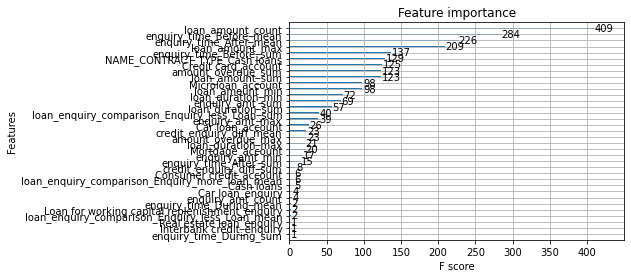

In [43]:
scale_pos_weight = sum(y_train == 0)/sum(y_train == 1) 
model = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
#model = XGBClassifier(scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
model.fit(X_train_encoded, y_train)

plot_importance(model)


In [44]:
y_pred_train = model.predict(X_train_encoded)
y_pred_train_prob = model.predict_proba(X_train_encoded)[:,1]
print('Train ')
performance(y_train,y_pred_train,y_pred_train_prob)
print('Test ')

y_pred_test = model.predict(X_test_encoded)
y_pred_test_prob = model.predict_proba(X_test_encoded)[:,1]
performance(y_test,y_pred_test,y_pred_test_prob)


Train 
f1 score  0.1906926430577257
Precision  0.11105172062716351
Recall  0.6741868191300316
Accuracy  0.6221784663099313
ROC-AUC  0.7119947515911231
[[113244  69850]
 [  4217   8726]]
Test 
f1 score  0.18671360584131952
Precision  0.10863298437262935
Recall  0.6638850254983774
Accuracy  0.6181862700088758
ROC-AUC  0.7016711344050922
[[37532 23500]
 [ 1450  2864]]


### On Complete Data for prediction on test data

In [45]:
std_all = StandardScaler()
X_encoded = std_all.fit_transform(X)
X_encoded = pd.DataFrame(X_encoded,columns = X.columns)

scale_pos_weight = sum(y == 0)/sum(y == 1)

In [52]:
### Check for CV score to ensure the results are consistent
xgb = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,
                    scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")

print(cross_val_score(xgb, X_encoded, y, cv=3,scoring='roc_auc'))

[0.70834366 0.7040509  0.70361959]


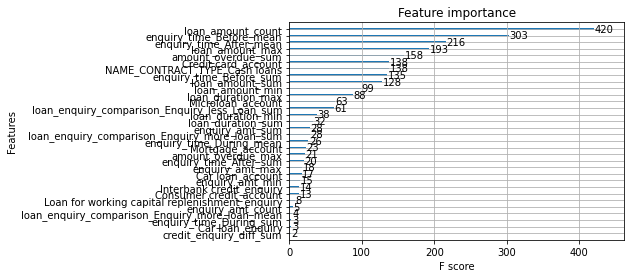

In [46]:
model_all = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
#model = XGBClassifier(scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
model_all.fit(X_encoded, y)

plot_importance(model_all)

In [47]:
y_pred = model_all.predict(X_encoded)
y_pred_prob = model_all.predict_proba(X_encoded)[:,1]
performance(y,y_pred,y_pred_prob)

f1 score  0.18920122775901585
Precision  0.1099698738467332
Recall  0.6768847424233644
Accuracy  0.6169796811575351
ROC-AUC  0.709868807464846
[[149587  94539]
 [  5576  11681]]


### Test Data Prediction

In [48]:
accounts_data_test['count_late_payment'] = accounts_data_test['payment_hist_string'].apply(count_bad_payment)

accounts_data_test['open_date'] = pd.to_datetime(accounts_data_test['open_date'])
accounts_data_test['closed_date'] = pd.to_datetime(accounts_data_test['closed_date'])

### Fill Null values : closed_date = open_date + payment_duration
accounts_data_test['closed_date'] = np.where(accounts_data_test['closed_date'].isna(),
                                              accounts_data_test[['open_date','payment_hist_string']].apply(lambda x: x[0] + pd.DateOffset(months=len(x[1])//3),axis=1),
                                              accounts_data_test['closed_date'])
accounts_data_test['loan_duration'] = (accounts_data_test['closed_date'] - accounts_data_test['open_date']).dt.days

### Make all credit type in columns and fill values with count of rows for each uid
credit_type_count_test = pd.crosstab(accounts_data_test['uid'],accounts_data_test['credit_type']).reset_index()
for col in credit_type_count.columns:
  if col not in credit_type_count_test.columns:
    credit_type_count_test[col] = 0
### UID level for amount variables
credit_amounts_test = accounts_data_test.groupby(['uid']).agg({'loan_amount':['sum','min','max','count'],
                                                     'amount_overdue':['sum','min','max','count'],
                                                     'count_late_payment':['sum','min','max','count'],
                                                     'loan_duration':['sum','min','max','count']}).reset_index()
credit_amounts_test.columns = credit_amounts_test.columns.map('_'.join)
credit_amounts_test.rename(columns={'uid_':'uid'},inplace=True)

for col in credit_amounts.columns:
  if col not in credit_amounts_test.columns:
    credit_amounts_test[col] = 0

uid_level_test = pd.merge(credit_type_count_test,credit_amounts_test,how='inner',on=['uid'])
### Merge with test_Flag
uid_level_test = pd.merge(uid_level_test,test_flag,how='inner',on=['uid'])
uid_level_test.fillna(0,inplace=True)
uid_level_test = pd.get_dummies(uid_level_test,columns=['NAME_CONTRACT_TYPE']) #Only categorcial column
uid_level_test.isna().sum().sum()

enquiry_type_count_test = pd.crosstab(enquiry_data_test['uid'],enquiry_data_test['enquiry_type']).reset_index()
enquiry_amt_test = enquiry_data_test.groupby(['uid']).agg({'enquiry_amt':['sum','min','max','count']}).reset_index()
enquiry_amt_test.columns = enquiry_amt_test.columns.map('_'.join)
enquiry_amt_test.rename(columns={'uid_':'uid'},inplace=True)
enquiry_test = pd.merge(enquiry_type_count_test,enquiry_amt_test,how='inner',on=['uid'])
enquiry_test.fillna(0,inplace=True)
enquiry_test.isna().sum().sum()

uid_level_test = pd.merge(uid_level_test,enquiry_test,how='right',on=['uid'],suffixes=('_account','_enquiry'))
uid_level_test.fillna(0,inplace=True)
uid_level_test.shape

(46127, 55)

In [49]:
date_features_test = pd.merge(accounts_data_test[['uid','credit_type','loan_amount', 'amount_overdue', 'open_date',
       'closed_date']],
       enquiry_data_test, how='inner',on=['uid'])

date_features_test['enquiry_time'] = np.where(date_features_test['open_date'] > date_features_test['enquiry_date'],'Before',
                                         np.where(date_features_test['closed_date'] < date_features_test['enquiry_date'],'After','During'))

date_features_test['loan_enquiry_comparison'] = np.where(date_features_test['enquiry_amt'] < date_features_test['loan_amount'],'Enquiry_less_Loan',
                                                    'Enquiry_more_loan')
date_features_test['credit_enquiry'] = np.where(date_features_test['credit_type'] == date_features_test['enquiry_type'],'same','diff') 
date_features_test = pd.get_dummies(date_features_test,columns=['enquiry_time','loan_enquiry_comparison','credit_enquiry'])

for col in date_features.columns:
  if col not in date_features_test.columns:
    date_features_test[col] = 0

date_features_test = date_features_test.groupby(['uid']).agg({'enquiry_time_After':['sum','mean','max','min'],
                                    'enquiry_time_Before':['sum','mean','max','min'],
                                    'enquiry_time_During':['sum','mean','max','min'],
       'loan_enquiry_comparison_Enquiry_less_Loan':['sum','mean','max','min'],
       'loan_enquiry_comparison_Enquiry_more_loan':['sum','mean','max','min'], 'credit_enquiry_diff':['sum','mean','max','min'],
       'credit_enquiry_same':['sum','mean','max','min']}).reset_index()

date_features_test.columns = date_features_test.columns.map('_'.join)
date_features_test.rename(columns={'uid_':'uid'},inplace=True)
date_features_test.head()

uid_level_test = pd.merge(uid_level_test,date_features_test,how='left',on=['uid'])
uid_level_test.fillna(0,inplace=True)
uid_level_test.shape


(46127, 83)

In [50]:
X_test = uid_level_test.drop(columns=['uid'])
X_test = X_test[X.columns]
X_test_encoded = std_all.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded,columns = X_test.columns)

uid_level_test['pred_prob'] = model_all.predict_proba(X_test_encoded)[:,1]

In [51]:
sub = pd.merge(sub,uid_level_test[['uid','pred_prob']],how = 'left',on='uid')
sub['pred'] = sub['pred_prob']
sub[['uid','pred']].to_csv('senior_ds_test/data/final_submission/final_submission_Santanu_Datta.csv',index=0)

### Hyper Param Optimization & Experiments

In [ ]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 500
#     }

# def hyperparameter_tuning(space):
#     model = XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                          reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
#                          colsample_bytree=space['colsample_bytree'],scale_pos_weight=round(scale_pos_weight))
#     evaluation = [( X_train_encoded, y_train), ( X_test_encoded, y_test)]
    
#     model.fit(X_train_encoded, y_train,
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)

#     pred = model.predict_proba(X_test_encoded)[:,1]
#     score = roc_auc_score(y_test, pred>0.5)
#     print ("SCORE:", score)
#     #change the metric if you like
#     return {'loss': -score, 'status': STATUS_OK, 'model': model}

# trials = Trials()
# best = fmin(fn=hyperparameter_tuning,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials)

# print (best)

In [ ]:
### Experiment with RandomForestClassifier
rf = RandomForestClassifier()

print(cross_val_score(rf, X_encoded, y, cv=3,scoring='roc_auc'))